1) - в Podcast_Name есть названия, которые можно определить по категориям и типам, просто кодировать мало. Пропусков нет

2) - есть строки, в которых Episode_Length_minutes меньше Listening_Time_minutes, то есть человек слушал не один раз. Создать новую колонку с числом прослушивания.Нет, тх нужно дропать потмоук что одна из колонок это таргет. к тому же их 2.5к из 750к

3) + заменил tr[tr['Number_of_Ads'] > 12] на -1, странно большие значения числав рекламы. При этом их значение очень похоже на таргет. a = tr[tr['Number_of_Ads'] > 12]
    a['Number_of_Ads'] - a['Listening_Time_minutes']

4) - в Episode_Length_minutes есть нулевые и просто маленькие занчения

5) - Возможно потерял инфомрацию при кодировании жанра

6) - в Host_Popularity_percentage есть низкие значения типа 2.9 а потом сразу 20, резкий скачок. Есть значения больше 100

7) - Publication_Day циклическая фича, кодировал без учета этого

8) - Publication_Time циклическая фича, кодировал без учета этого

9) - Guest_Popularity_percentage мно8го пропусков, есть значения больше 100

10) - Один пропуск, много нулей и значений до 4, есть выбрасы до 102

11) - Episode_Sentiment закодировал одно из значений как -1, не хорошо, сбивает с толку

12) - Listening_Time_minutes таргет, но есть значение 119, такое же как выбрасы на процентах, это стртанно 

13) - Можно попробовать уделить строки у которых больше 5 стоолбцов с одинаковым значением. Только после удаления явных выбрасов

1) Использует target encoder

2) Заоплняет пропуски средним и создает колонку с флагом того, что тут был пропуск

3) Использует синус и косинус для циклических переменных

4) комбитнации признаков(буквально создаются ._col1_col2_...) кодируются через таргет кодирование



In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.preprocessing import TargetEncoder  # Новый встроенный энкодер
from sklearn.preprocessing import QuantileTransformer
from itertools import combinations


In [84]:
tr = pd.read_csv('data\\train.csv')
tst = pd.read_csv('data\\test.csv')

In [85]:
podcast_type_mapping = {
    # Новости и аналитика
    'News Roundup': 1,
    'Global News': 1,
    'World Watch': 1,
    'Current Affairs': 1,
    
    # Технологии и гаджеты
    'Tech Talks': 2,
    'Tech Trends': 2,
    'Gadget Geek': 2,
    'Digital Digest': 2,
    'Innovators': 2,
    
    # Спорт
    'Sports Central': 3,
    'Sports Weekly': 3,
    'Sport Spot': 3,
    'Game Day': 3,
    "Athlete's Arena": 3,
    
    # Юмор
    'Comedy Corner': 4,
    'Funny Folks': 4,
    'Humor Hub': 4,
    'Laugh Line': 4,
    'Joke Junction': 4,
    
    # Здоровье и образ жизни
    'Fitness First': 5,
    'Mind & Body': 5,
    'Wellness Wave': 5,
    'Healthy Living': 5,
    'Health Hour': 5,
    'Home & Living': 5,
    'Lifestyle Lounge': 5,
    
    # Бизнес и финансы
    'Business Briefs': 6,
    'Money Matters': 6,
    'Finance Focus': 6,
    'Market Masters': 6,
    'Business Insights': 6,
    
    # Музыка
    'Music Matters': 7,
    'Melody Mix': 7,
    'Sound Waves': 7,
    'Tune Time': 7,
    
    # Образование и наука
    'Study Sessions': 8,
    'Learning Lab': 8,
    'Educational Nuggets': 8,
    'Brain Boost': 8,
    'Life Lessons': 8,
    
    # Криминал и детективы
    'Criminal Minds': 9,
    'Crime Chronicles': 9,
    'Detective Diaries': 9,
    'True Crime Stories': 9,
    
    # Мода
    'Fashion Forward': 10,
    'Style Guide': 10,
    
    # Разное (если не входит в другие категории)
    'Mystery Matters': 11,
    'Daily Digest': 12,
}

In [86]:
podcast_author_mapping = {
    # Авторские группы по ключевым словам
    'Music Matters': 1,   #Matters Media
    'Money Matters': 1,
    'Mystery Matters': 1,
    
    'Daily Digest': 2,    #Digest Network
    'Digital Digest': 2,
    
    'Sports Central': 3,  #Sports Network
    'Sports Weekly': 3,

    'Tech Talks': 4,  #Tech Media
    'Tech Trends': 4,
    
    'Business Briefs': 5,     #Business Media
    'Business Insights': 5,
    
    'Study Sessions': -1,
    'Learning Lab': -1,
    'Educational Nuggets': -1,
    'Brain Boost': -1,
    'Fashion Forward': -1,
    'Style Guide': -1,
    'Game Day': -1,
    'Athlete\'s Arena': -1,
    'Innovators': -1,
    'Home & Living': -1,
    'Lifestyle Lounge': -1,
    'Life Lessons': -1,
    'Sport Spot': -1,
    'Comedy Corner': -1,
    'Humor Hub': -1,
    'Funny Folks': -1,
    'Laugh Line': -1,
    'Joke Junction': -1,
    'Gadget Geek': -1,
    'News Roundup': -1,
    'Global News': -1,
    'World Watch': -1,
    'Current Affairs': -1,
    'Fitness First': -1,
    'Mind & Body': -1,
    'Wellness Wave': -1,
    'Healthy Living': -1,
    'Health Hour': -1,
    'Market Masters': -1,
    'Finance Focus': -1,
    'Melody Mix': -1,
    'Sound Waves': -1,
    'Tune Time': -1,
    'Criminal Minds': -1,
    'True Crime Stories': -1,
    'Crime Chronicles': -1,
    'Detective Diaries': -1,
}



In [87]:
def df_fix(df):
    df['Episode_Title'] = df['Episode_Title'].str.split(' ').str[1].astype(int)

    dct_Publication_Time = {'Morning': 0, 'Afternoon': 1, 'Evening': 2, 'Night': 3}
    df['Publication_Time'] = df['Publication_Time'].map(dct_Publication_Time)
    
    df['Genre'] = df['Genre'].factorize()[0]
    df['Publication_Day'] = df['Publication_Day'].factorize()[0]

    dct_Episode_Sentiment = {'Positive': 1, 'Negative': -1, 'Neutral': 0}
    df['Episode_Sentiment'] = df['Episode_Sentiment'].map(dct_Episode_Sentiment)

    #df['Number_of_Ads'] = df['Number_of_Ads'].mask(df['Number_of_Ads'] > 12, -1)
    df['Number_of_Ads'] = df['Number_of_Ads'].fillna(df['Number_of_Ads'].mode()[0])

    df['Podcast_Type'] = df['Podcast_Name'].map(podcast_type_mapping)
    df['Podcast_Author'] = df['Podcast_Name'].map(podcast_author_mapping)

    num_cols = df.select_dtypes(exclude=['object']).columns.tolist()

    for c in num_cols:
        if df[c].isna().any():
            m = df[c].mean()
            df[f'NA_{c}'] = df[c].isna().astype('int8')
            df[c] = df[c].fillna(m)
    
    return df

In [88]:
def feat_eng(df, encode_cols):
    time_dict = {'Morning': 0, 'Afternoon': 1, 'Evening': 2, 'Night': 3}
    pair_size = [2, 3, 4]

    df['_Has_Ads'] = (df['Number_of_Ads'] > 0).astype('int8')
    df['_Is_Weekend'] = df['Publication_Day'].isin(['Saturday', 'Sunday']).astype('int8')
    df['_sin_Episode_Length_minutes'] = np.sin(2*np.pi * df['Episode_Length_minutes'] / 60)
    df['_cos_Episode_Length_minutes'] = np.cos(2*np.pi * df['Episode_Length_minutes'] / 60)
    df['_sin_Host_Popularity_percentage'] = np.sin(2*np.pi * df['Host_Popularity_percentage'] / 20)
    df['_cos_Host_Popularity_percentage'] = np.cos(2*np.pi * df['Host_Popularity_percentage'] / 20)

    df['Publication_Time_enc'] = df['Publication_Time'].replace(time_dict)
    df['_sin_Publication_Time'] = np.sin(2*np.pi * df['Publication_Time_enc'] / 2)
    df['_cos_Publication_Time'] = np.cos(2*np.pi * df['Publication_Time_enc'] / 2)
    for r in pair_size:
        for cols in list(combinations(encode_cols, r)):
            new_col_name = '_'.join(cols)
            df['._'+new_col_name] = df[list(cols)].astype(str).agg('_'.join, axis=1)
            
    df = df.drop(['Publication_Time_enc'], axis=1)
    new_num_cols = [col for col in df.columns if col.startswith('_')]
    new_enc_cols = [col for col in df.columns if col.startswith('.')]
    return df, new_num_cols, new_enc_cols 

In [89]:
def target_encoding(train, target, test=None, feat_to_encode=None, min_samples_leaf=20, smoothing=10.0):
    train = train.copy()
    if test is not None:
        test = test.copy()
    
    train.sort_index(inplace=True)

    if feat_to_encode is None:
        feat_to_encode = train.columns.tolist()
        
    oof_parts = []
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    for tr_idx, oof_idx in kf.split(train, target):
        encoder = TargetEncoder(smooth="auto")  # новый sklearn TargetEncoder
        encoder.fit(train.iloc[tr_idx][feat_to_encode], target.iloc[tr_idx])
        encoded = encoder.transform(train.iloc[oof_idx][feat_to_encode])
        encoded_df = pd.DataFrame(encoded, columns=feat_to_encode, index=train.iloc[oof_idx].index)
        oof_parts.append(encoded_df)

    if test is not None:
        final_encoder = TargetEncoder(smooth="auto")
        final_encoder.fit(train[feat_to_encode], target)
        test[feat_to_encode] = final_encoder.transform(test[feat_to_encode])
    
    train_encoded = pd.concat(oof_parts).sort_index()
    train[feat_to_encode] = train_encoded[feat_to_encode]
    return train, test

In [90]:
tr = df_fix(tr)
tst = df_fix(tst)

In [91]:
tr

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes,Podcast_Type,Podcast_Author,NA_Episode_Length_minutes,NA_Guest_Popularity_percentage
0,0,Mystery Matters,98,64.504738,0,74.81,0,3,52.236449,0.0,1,31.41998,11,1,1,1
1,1,Joke Junction,26,119.800000,1,66.95,1,1,75.950000,2.0,-1,88.01241,4,-1,0,0
2,2,Study Sessions,16,73.900000,2,69.97,2,2,8.970000,0.0,-1,44.92531,8,-1,0,0
3,3,Digital Digest,45,67.170000,3,57.22,3,0,78.700000,2.0,1,46.27824,2,2,0,0
4,4,Mind & Body,86,110.510000,4,80.07,3,1,58.680000,3.0,0,75.61031,5,-1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,749995,Learning Lab,25,75.660000,2,69.36,1,0,52.236449,0.0,-1,56.87058,8,-1,0,1
749996,749996,Business Briefs,21,75.750000,8,35.21,1,3,52.236449,2.0,0,45.46242,6,5,0,1
749997,749997,Lifestyle Lounge,51,30.980000,9,78.58,0,0,84.890000,0.0,-1,15.26000,5,-1,0,0
749998,749998,Style Guide,47,108.980000,9,45.39,0,0,93.270000,0.0,-1,100.72939,10,-1,0,0


In [92]:
encode_cols = ['Episode_Length_minutes', 'Host_Popularity_percentage', 'Number_of_Ads', 'Episode_Title', 'Episode_Sentiment', 'Publication_Time', 'Publication_Day']

X, new_num_cols, new_enc_cols = feat_eng(tr, encode_cols)
X_test, new_num_cols, new_enc_cols = feat_eng(tst, encode_cols)

C:\Users\Admin\AppData\Local\Temp\ipykernel_19052\2190119035.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['._'+new_col_name] = df[list(cols)].astype(str).agg('_'.join, axis=1)
C:\Users\Admin\AppData\Local\Temp\ipykernel_19052\2190119035.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['._'+new_col_name] = df[list(cols)].astype(str).agg('_'.join, axis=1)
C:\Users\Admin\AppData\Local\Temp\ipykernel_19052\2190119035.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `

In [ ]:
X, X_test = target_encoding(tr, tr.Listening_Time_minutes, tst, feat_to_encode=new_enc_cols)
num_cols = list(set(X.select_dtypes(exclude=['object']).columns.tolist()) - set(['Listening_Time_minutes']))

scaler = QuantileTransformer(subsample=10**9)
X[num_cols] = scaler.fit_transform(X[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

X = X.drop(columns=['Podcast_Name'])
y = tr.Listening_Time_minutes
X_test = X_test.drop(columns=['Podcast_Name'])

AttributeError: 'DataFrame' object has no attribute 'Listening_Time_minutes'

Перед запускорм нужно создать X - это трейн без таргета, y - сам таргет, X_test - tst 


Fold 1
Training until validation scores don't improve for 100 rounds
[500]	training's rmse: 11.9195	valid_1's rmse: 12.2806
[1000]	training's rmse: 11.5717	valid_1's rmse: 12.2578
[1500]	training's rmse: 11.269	valid_1's rmse: 12.2514
Early stopping, best iteration is:
[1610]	training's rmse: 11.2087	valid_1's rmse: 12.2492
Fold 1 RMSE: 12.2492

Fold 2
Training until validation scores don't improve for 100 rounds
[500]	training's rmse: 11.919	valid_1's rmse: 12.2623
Early stopping, best iteration is:
[815]	training's rmse: 11.6892	valid_1's rmse: 12.2406
Fold 2 RMSE: 12.2406

Fold 3
Training until validation scores don't improve for 100 rounds
[500]	training's rmse: 11.9147	valid_1's rmse: 12.3243
[1000]	training's rmse: 11.5617	valid_1's rmse: 12.3025
[1500]	training's rmse: 11.2687	valid_1's rmse: 12.2916
[2000]	training's rmse: 11.0094	valid_1's rmse: 12.2866
Early stopping, best iteration is:
[2060]	training's rmse: 10.9801	valid_1's rmse: 12.2852
Fold 3 RMSE: 12.2852

Fold 4
Trai

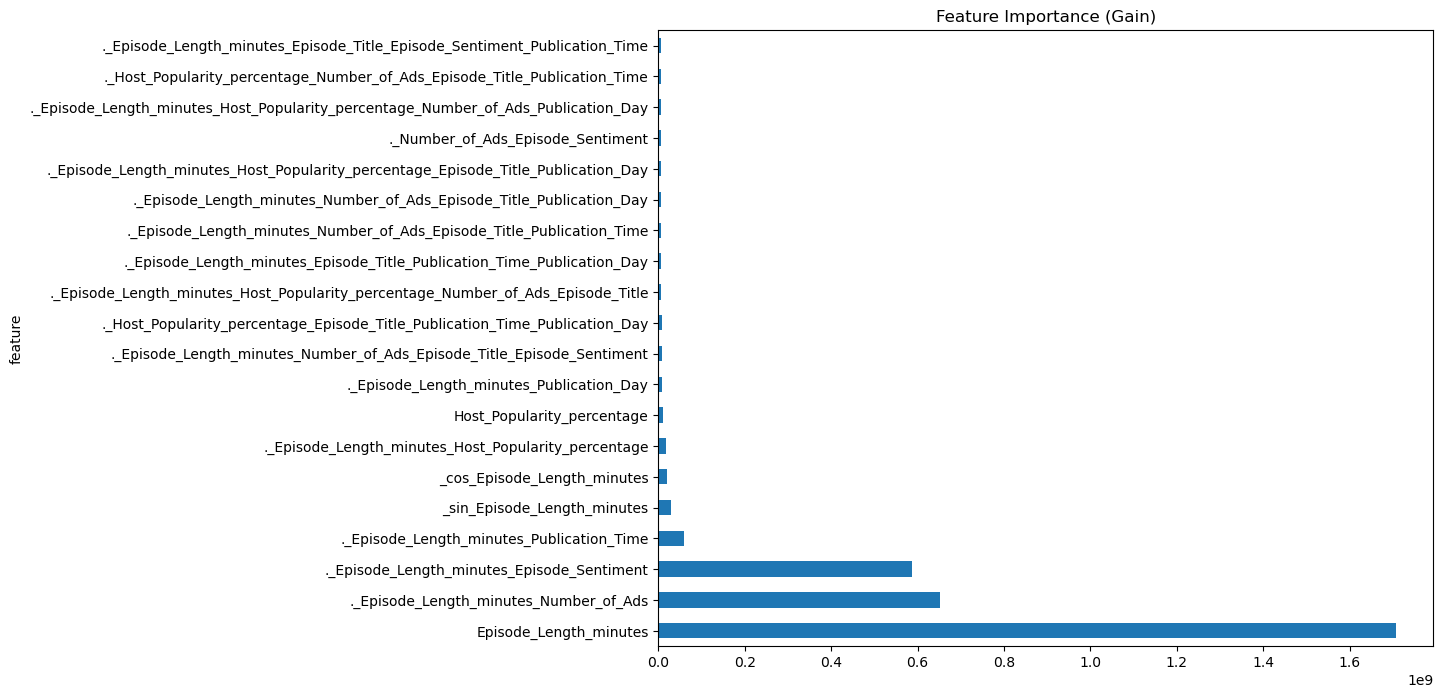

CPU times: total: 48min 32s
Wall time: 4min 23s


In [108]:
%%time
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Prepare data
X_train = X.copy()
y_train = y.copy()

# LightGBM parameters (fixed typos and added more common parameters)
lgb_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',  # Fixed typo
    'learning_rate': 0.05,
    'num_leaves': 31,
    'min_child_samples': 20,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,  # Fixed typo
    'bagging_freq': 1,
    'lambda_l1': 0.1,
    'lambda_l2': 0.1,
    'verbose': -1,
    'random_state': 42
}

# KFold validation
n_folds = 9
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
oof_preds = np.zeros(X_train.shape[0])
test_preds = np.zeros(X_test.shape[0])
feature_importance = pd.DataFrame()

for fold, (train_idx, valid_idx) in enumerate(kf.split(X_train, y_train)):
    print(f"\nFold {fold + 1}")
    
    # Split data
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[valid_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[valid_idx]
    
    # Create LightGBM datasets
    train_set = lgb.Dataset(X_tr, y_tr)
    valid_set = lgb.Dataset(X_val, y_val, reference=train_set)
    
    # Train model with callbacks instead of early_stopping_rounds parameter
    model = lgb.train(
        params=lgb_params,
        train_set=train_set,
        num_boost_round=10000,
        valid_sets=[train_set, valid_set],
        callbacks=[
            lgb.early_stopping(stopping_rounds=100),  # Early stopping callback
            lgb.log_evaluation(500)  # Replaces verbose_eval
        ]
    )
    
    # Predictions
    oof_preds[valid_idx] = model.predict(X_val, num_iteration=model.best_iteration)
    test_preds += model.predict(X_test, num_iteration=model.best_iteration) / n_folds
    
    # Feature importance
    fold_importance = pd.DataFrame({
        "feature": X_train.columns,
        "importance": model.feature_importance(importance_type='gain'),
        "fold": fold + 1
    })
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
    # Fold evaluation
    fold_rmse = np.sqrt(mean_squared_error(y_val, oof_preds[valid_idx]))
    print(f"Fold {fold + 1} RMSE: {fold_rmse:.4f}")

# Overall evaluation
total_rmse = np.sqrt(mean_squared_error(y_train, oof_preds))
print(f"\nOverall OOF RMSE: {total_rmse:.4f}")

# Feature importance visualization
(feature_importance.groupby('feature')['importance']
                   .mean()
                   .sort_values(ascending=False)
                   .head(20)
                   .plot(kind='barh', figsize=(10, 8), title='Feature Importance (Gain)'))
plt.show()

In [109]:

# Подготовка submission файла
submission = pd.DataFrame({
    'id': tst['id'],
    'Listening_Time_minutes': test_preds
})
submission


,id,Listening_Time_minutes
0,750000,56.513289
1,750001,21.005028
2,750002,61.717474
3,750003,83.018465
4,750004,50.526763
...,...,...
249995,999995,10.387985
249996,999996,59.717018
249997,999997,6.534697
249998,999998,73.926543


In [110]:
submission.to_csv('lgb_submission_1.csv', index=False)
print("\nSubmission file saved!")


Submission file saved!
